## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score, f1_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F

## Parameters

In [2]:
BATCH_SIZE = 64
NUM_CLASSES = 3
T = 1

PRIORS = {
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0.0, 0.1),
    'posterior_rho_initial': (-3.0, 0.1)
}  

SITE = 'C'
YEAR = 2021

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Loading Files

In [3]:
X = np.load(f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy')
y = np.load(f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy')

print(f'Loaded Data of Site {SITE} - {YEAR}')
print(X.shape, y.shape)

Loaded Data of Site C - 2021
(2242176, 28, 6) (2242176,)


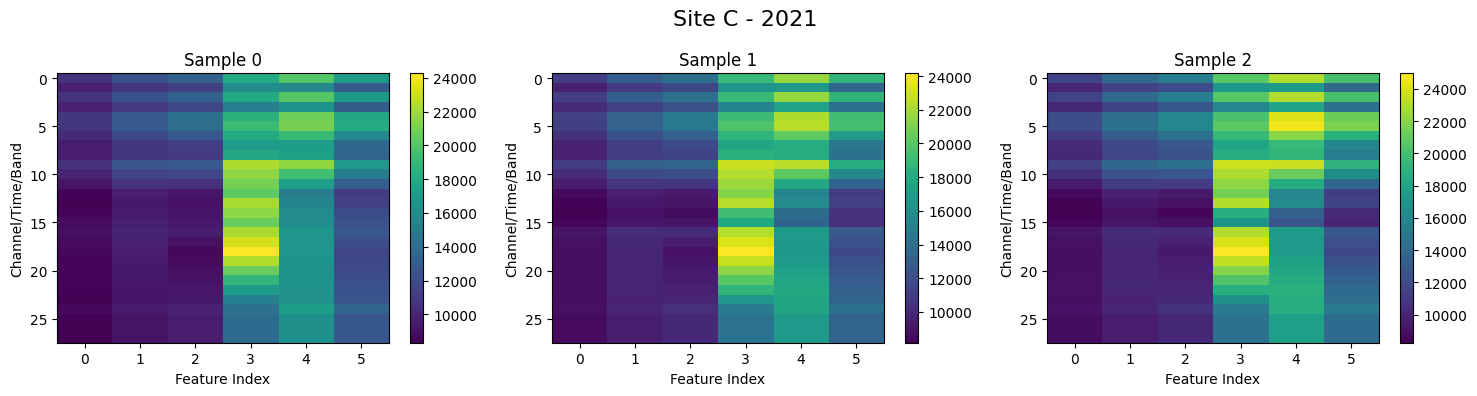

In [4]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site C - 2021 =======
Feature 0: Mean = 9535.8166, Std = 3084.4035
Feature 1: Mean = 10678.5843, Std = 2977.6013
Feature 2: Mean = 10704.5150, Std = 3321.3854
Feature 3: Mean = 19265.3258, Std = 4190.0847
Feature 4: Mean = 15453.4716, Std = 3517.5318
Feature 5: Mean = 12151.4443, Std = 3340.2324

Global Mean: 12964.8596
Global Std Dev: 4815.6603


## Pre-processing the Input

In [6]:
# Standardizing the input features across all timesteps and samples using Z-scores
# Compute per-feature mean and std across all samples and timesteps
feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
feature_stds = X.std(axis=(0, 1))    # Shape: (6,)

# Reshape for broadcasting
feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)

# Standardize
X = ((X - feature_means) / feature_stds).astype(np.float32)

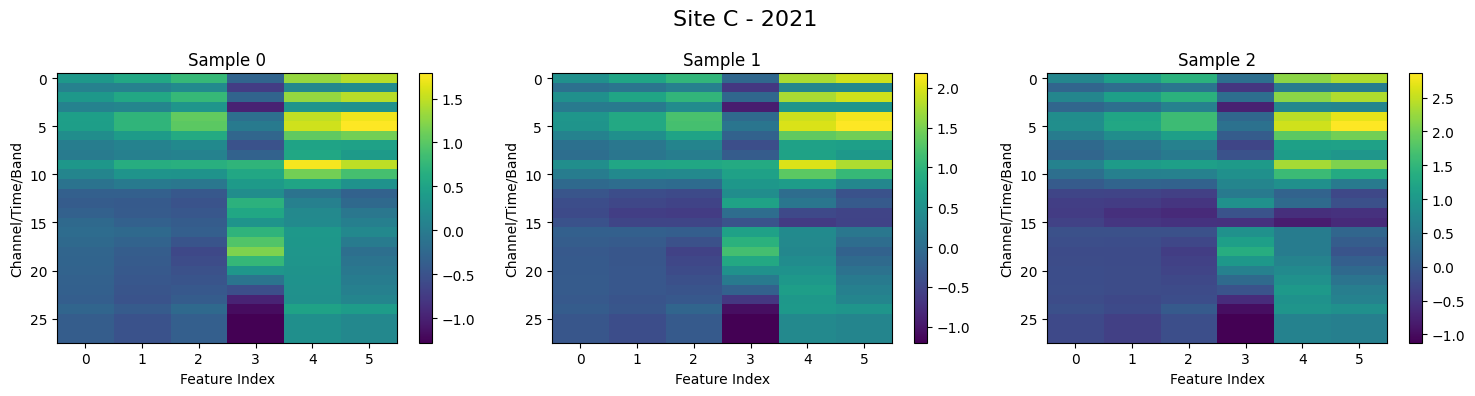

In [7]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site C - 2021 =======
Feature 0: Mean = 0.0000, Std = 0.9372
Feature 1: Mean = 0.0000, Std = 0.9138
Feature 2: Mean = 0.0002, Std = 0.8818
Feature 3: Mean = -0.0000, Std = 0.8977
Feature 4: Mean = -0.0001, Std = 0.8943
Feature 5: Mean = -0.0002, Std = 0.8654

Global Mean: 0.0000
Global Std Dev: 1.0000


## Label Distribution



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         896726    39.99%
1         299398    13.35%
2         1046052   46.65%

Total samples: 2242176


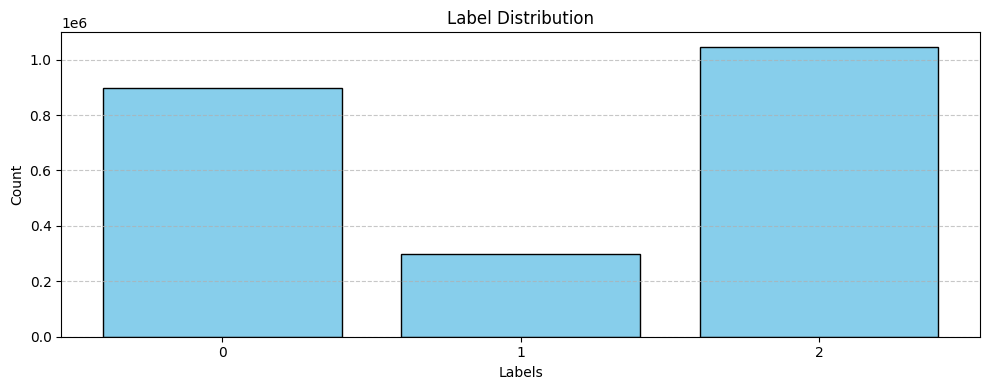

In [9]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution ======')
unique_labels, counts = np.unique(y, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Dataset and DataLoader

In [10]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
full_dataset = Conv1dDataset(X, y)
full_dataloader = DataLoader(full_dataset, batch_size=BATCH_SIZE)

## Model Definition and Initialization

In [12]:
# KL Divergence Helper
########################################
def KL_DIV(mu_q, sig_q, mu_p, sig_p):
    return 0.5 * (2 * torch.log(sig_p / sig_q) - 1 +
                  (sig_q / sig_p).pow(2) +
                  ((mu_p - mu_q) / sig_p).pow(2)).sum()

In [13]:
# Wrappers
########################################
class ModuleWrapperLinear(nn.Module):
    """Wrapper for nn.Module (Linear) with support for sample & n_samples propagation"""
    def __init__(self):
        super(ModuleWrapperLinear, self).__init__()

    def set_flag(self, flag_name, value):
        setattr(self, flag_name, value)
        for m in self.children():
            if hasattr(m, 'set_flag'):
                m.set_flag(flag_name, value)

    def forward(self, x, sample=True, n_samples=1):
        # x can be (batch, features) or (n_samples, batch, features)
        for module in self.children():
            name = module._get_name()
            # If module is a BBB layer, pass sample & n_samples
            if 'BBB' in name:
                x = module(x, sample=sample, n_samples=n_samples)
            else:
                # Non-BBB modules (activations, etc.)
                # If x has samples dim, merge before applying, then unmerge
                if x.dim() == 3:
                    n, b, f = x.shape
                    x = x.reshape(n * b, f)        # <-- changed .view -> .reshape
                    x = module(x)
                    # If module changes feature size, recompute new feature dim
                    new_f = x.shape[1]
                    x = x.reshape(n, b, new_f)    # <-- changed .view -> .reshape
                else:
                    x = module(x)
        # compute kl from all modules that have kl_loss (independent of n_samples)
        kl = torch.tensor(0.0, device=x.device)
        for module in self.modules():
            if hasattr(module, 'kl_loss') and module is not self:
                kl = kl + module.kl_loss()
        return x, kl


class ModuleWrapperConv1d(nn.Module):
    """Wrapper for nn.Module (Conv1D) with support for sample & n_samples propagation"""
    def __init__(self):
        super(ModuleWrapperConv1d, self).__init__()

    def set_flag(self, flag_name, value):
        setattr(self, flag_name, value)
        for m in self.children():
            if hasattr(m, 'set_flag'):
                m.set_flag(flag_name, value)

    def forward(self, x, sample=True, n_samples=1):
        for module in self.children():
            name = module._get_name()
            if 'BBB' in name:
                x = module(x, sample=sample, n_samples=n_samples)
            else:
                if x.dim() == 4:
                    n, b, c, l = x.shape
                    x = x.reshape(n * b, c, l)
                    x = module(x)
                    new_c, new_l = x.shape[1], x.shape[2]
                    x = x.reshape(n, b, new_c, new_l)
                else:
                    x = module(x)
        kl = torch.tensor(0.0, device=x.device)
        for module in self.modules():
            if hasattr(module, 'kl_loss') and module is not self:
                kl = kl + module.kl_loss()
        return x, kl

In [14]:
# BBBLinear
########################################
class BBBLinear(ModuleWrapperLinear):
    def __init__(self, in_features, out_features, bias=True, priors=None, device='cpu'):
        super(BBBLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = bias
        self.device = device

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        self.W_mu  = Parameter(torch.empty((out_features, in_features), device=self.device))
        self.W_rho = Parameter(torch.empty((out_features, in_features), device=self.device))

        if self.use_bias:
            self.bias_mu  = Parameter(torch.empty((out_features), device=self.device))
            self.bias_rho = Parameter(torch.empty((out_features), device=self.device))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)
        if self.use_bias:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def _compute_sigma(self):
        # stable softplus
        W_sigma = torch.log1p(torch.exp(self.W_rho))
        if self.use_bias:
            bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        else:
            bias_sigma = None
        return W_sigma, bias_sigma

    def forward(self, input, sample=True, n_samples=1):
        """
        input: (batch, in_features)  OR  (n_samples, batch, in_features)
        returns:
            if n_samples>1: outputs (n_samples, batch, out_features)
            else: outputs (batch, out_features)
        """
        W_sigma, bias_sigma = self._compute_sigma()
        self.W_sigma = W_sigma            # keep attributes for kl_loss
        if self.use_bias:
            self.bias_sigma = bias_sigma

        # Case A: sample=True and n_samples>1 -> vectorized multiple draws
        if sample and n_samples > 1:
            if input.dim() == 2:
                batch_in = input.unsqueeze(0).expand(n_samples, input.size(0), input.size(1))  # (n, b, i)
            else:
                # input already shaped (n_input, b, i)
                batch_in = input
                if batch_in.shape[0] != n_samples:
                    batch_in = batch_in[0].unsqueeze(0).expand(n_samples, *batch_in.shape[1:])

            # sample weights for all n at once
            W_eps = torch.randn((n_samples, *self.W_mu.size()), device=self.device)  # (n, out, in)
            weights = self.W_mu.unsqueeze(0) + W_sigma.unsqueeze(0) * W_eps             # (n, out, in)

            # batch_in: (n, b, in); weights: (n, out, in)
            outputs = torch.einsum('noi,nbi->nbo', weights, batch_in)

            if self.use_bias:
                bias_eps = torch.randn((n_samples, *self.bias_mu.size()), device=self.device)  # (n, out)
                biases = self.bias_mu.unsqueeze(0) + bias_sigma.unsqueeze(0) * bias_eps       # (n, out)
                outputs = outputs + biases.unsqueeze(1)  # (n, b, out)
            return outputs

        # Case B: sample=True and n_samples == 1 -> single stochastic draw
        if sample and n_samples == 1:
            W_eps = torch.randn(self.W_mu.size(), device=self.device)
            weight = self.W_mu + W_eps * W_sigma
            if self.use_bias:
                bias_eps = torch.randn(self.bias_mu.size(), device=self.device)
                bias = self.bias_mu + bias_eps * bias_sigma
            else:
                bias = None
            # input must be (batch, in) or (n, b, f)
            if input.dim() == 3:
                n, b, f = input.shape
                flat = input.reshape(n * b, f)                # <-- reshape
                out_flat = F.linear(flat, weight, bias)
                out = out_flat.reshape(n, b, -1)              # <-- reshape
                return out
            else:
                return F.linear(input, weight, bias)

        # Case C: deterministic (use mu)
        weight = self.W_mu
        if self.use_bias:
            bias = self.bias_mu
        else:
            bias = None
        if input.dim() == 3:
            n, b, f = input.shape
            flat = input.reshape(n * b, f)                    # <-- reshape
            out_flat = F.linear(flat, weight, bias)
            out = out_flat.reshape(n, b, -1)                  # <-- reshape
            return out
        else:
            return F.linear(input, weight, bias)

    def kl_loss(self):
        # ensure W_sigma and bias_sigma exist
        if not hasattr(self, 'W_sigma'):
            self.W_sigma, _ = self._compute_sigma()
        kl = KL_DIV(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            if not hasattr(self, 'bias_sigma'):
                _, self.bias_sigma = self._compute_sigma()
            kl += KL_DIV(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)
        return kl


########################################
# BBBConv1d
########################################
# ---- Bayesian Conv1D ----
class BBBConv1d(ModuleWrapperConv1d):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1,
                 bias=True, priors=None, device='cpu'):
        super(BBBConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size,)
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.use_bias = bias
        self.device = device

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        # Parameters for weight posterior
        self.W_mu = Parameter(torch.empty(out_channels, in_channels // groups, *self.kernel_size, device=self.device))
        self.W_rho = Parameter(torch.empty(out_channels, in_channels // groups, *self.kernel_size, device=self.device))

        if self.use_bias:
            self.bias_mu = Parameter(torch.empty(out_channels, device=self.device))
            self.bias_rho = Parameter(torch.empty(out_channels, device=self.device))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)
        if self.use_bias:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def _compute_sigma(self):
        W_sigma = torch.log1p(torch.exp(self.W_rho))
        bias_sigma = torch.log1p(torch.exp(self.bias_rho)) if self.use_bias else None
        return W_sigma, bias_sigma

    def forward(self, input, sample=True, n_samples=1):
        W_sigma, bias_sigma = self._compute_sigma()
        self.W_sigma = W_sigma
        if self.use_bias:
            self.bias_sigma = bias_sigma

        # Case A: Multiple stochastic passes (vectorized)
        if sample and n_samples > 1:
            if input.dim() == 3:  # (batch, C, L)
                input = input.unsqueeze(0).expand(n_samples, *input.shape)
            else:
                if input.shape[0] != n_samples:
                    input = input[0].unsqueeze(0).expand(n_samples, *input.shape[1:])

            W_eps = torch.randn((n_samples, *self.W_mu.shape), device=self.device)
            weights = self.W_mu.unsqueeze(0) + W_sigma.unsqueeze(0) * W_eps

            outputs = []
            for i in range(n_samples):
                bias_i = None
                if self.use_bias:
                    bias_eps = torch.randn(self.bias_mu.shape, device=self.device)
                    bias_i = self.bias_mu + bias_sigma * bias_eps
                outputs.append(F.conv1d(input[i], weights[i], bias_i,
                                        stride=self.stride, padding=self.padding,
                                        dilation=self.dilation, groups=self.groups))
            return torch.stack(outputs, dim=0)

        # Case B: Single stochastic pass
        if sample and n_samples == 1:
            W_eps = torch.randn(self.W_mu.shape, device=self.device)
            weight = self.W_mu + W_sigma * W_eps
            bias = None
            if self.use_bias:
                bias_eps = torch.randn(self.bias_mu.shape, device=self.device)
                bias = self.bias_mu + bias_sigma * bias_eps
            return F.conv1d(input, weight, bias,
                            stride=self.stride, padding=self.padding,
                            dilation=self.dilation, groups=self.groups)

        # Case C: Deterministic
        return F.conv1d(input, self.W_mu, self.bias_mu if self.use_bias else None,
                        stride=self.stride, padding=self.padding,
                        dilation=self.dilation, groups=self.groups)

    def kl_loss(self):
        if not hasattr(self, 'W_sigma'):
            self.W_sigma, _ = self._compute_sigma()
        kl = KL_DIV(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            if not hasattr(self, 'bias_sigma'):
                _, self.bias_sigma = self._compute_sigma()
            kl += KL_DIV(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)
        return kl

In [15]:
# Blocks (Conv + FC) 
# ----------------------------
class Conv1d_BayesBlock(ModuleWrapperConv1d):
    """BBBConv1d + BN + ReLU inside a Conv1d wrapper"""
    def __init__(self, in_ch, out_ch, kernel_size, priors, device='cpu', padding=0):
        super().__init__()
        self.conv = BBBConv1d(in_ch, out_ch, kernel_size, padding=padding, priors=priors, device=device)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU()

class FCBayesBlock(ModuleWrapperLinear):
    """BBBLinear (optionally add activation if you want)"""
    def __init__(self, in_f, out_f, priors, device='cpu'):
        super().__init__()
        self.fc = BBBLinear(in_f, out_f, priors=priors, device=device)

In [16]:
########################################
# Bayesian CNN + FC Model
########################################
class BayesianCNN_FC(nn.Module):
    def __init__(self, priors, num_classes=3, device='cpu'):
        super().__init__()
        self.device = device
        self.conv1 = Conv1d_BayesBlock(6, 64, 5, priors, device=device, padding=2)
        self.conv2 = Conv1d_BayesBlock(64, 128, 5, priors, device=device, padding=2)
        self.conv3 = Conv1d_BayesBlock(128, 256, 5, priors, device=device, padding=2)
        self.conv4 = Conv1d_BayesBlock(256, 512, 5, priors, device=device, padding=2)
        self.conv5 = Conv1d_BayesBlock(512, 1024, 5, priors, device=device, padding=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = FCBayesBlock(1024, num_classes, priors, device=device)

    def forward(self, x, sample=True, n_samples=1):
        # x: (batch, channels, length)  OR  (n_samples, batch, channels, length)
        kl_total = torch.tensor(0.0, device=x.device)

        x, kl = self.conv1(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv2(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv3(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv4(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv5(x, sample=sample, n_samples=n_samples); kl_total += kl

        # global pool (handle sample dim)
        if x.dim() == 4:  # (T, B, C, L)
            T_, B_, C_, L_ = x.shape
            x = x.reshape(T_ * B_, C_, L_)
            x = self.global_pool(x)             # (T*B, C, 1)
            x = x.squeeze(-1)                   # (T*B, C)
            x = x.reshape(T_, B_, C_)           # (T, B, C)
        elif x.dim() == 3:  # (B, C, L)
            x = self.global_pool(x)             # (B, C, 1)
            x = x.squeeze(-1)                   # (B, C)
        else:
            raise ValueError(f"Unexpected shape: {x.shape}")

        x, kl_fc = self.fc(x, sample=sample, n_samples=n_samples)
        kl_total += kl_fc

        return x, kl_total

In [17]:
########################################
# Model Initialization
########################################
model = BayesianCNN_FC(priors=PRIORS, num_classes=3, device=DEVICE).to(DEVICE)
model = torch.compile(model, backend='eager')
print(model)

OptimizedModule(
  (_orig_mod): BayesianCNN_FC(
    (conv1): Conv1d_BayesBlock(
      (conv): BBBConv1d()
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (conv2): Conv1d_BayesBlock(
      (conv): BBBConv1d()
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (conv3): Conv1d_BayesBlock(
      (conv): BBBConv1d()
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (conv4): Conv1d_BayesBlock(
      (conv): BBBConv1d()
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (conv5): Conv1d_BayesBlock(
      (conv): BBBConv1d()
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (global_pool): AdaptiveAvgPool1d(output_size=1)
    (fc): FCBay

## Loading the Model

In [18]:
checkpoint = torch.load("/kaggle/input/bcnn/pytorch/default/1/BCNN.pth", map_location=torch.device("cpu"))
model.load_state_dict(checkpoint)

<All keys matched successfully>

## Evaluaion Metrics

In [19]:
def compute_accuracy_per_sample_mean(outputs, labels):
    """
    outputs: (T, B, C) or (B, C)
    """
    if outputs.dim() == 3:
        preds = outputs.argmax(dim=2)               # (T, B)
        eq = (preds == labels.unsqueeze(0))         # (T, B)
        return eq.float().mean(dim=1).mean().item() # avg over T, then scalar
    else:
        preds = outputs.argmax(dim=1)
        return (preds == labels).float().mean().item()

## Testing the Model

In [20]:
def validate(model, dataloader, T, device):
    sample_flag = (T > 1)
    
    all_preds = []
    all_labels = []
    total_acc = 0.0

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(dataloader, desc=f"Stochastic Validation (T={T})" if sample_flag else f"Deterministic Validation (T={T})"):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            
            outputs, _ = model(x_batch, sample=sample_flag, n_samples=T)  # (T,B,C) or (B,C)

            # Accuracy before averaging predictions
            total_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

            # Average over stochastic passes if T>1
            if sample_flag and outputs.dim() == 3:
                outputs = outputs.mean(dim=0)  # (B, C)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)  # (B, C)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ====== Metrics ======
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    acc = total_acc / len(dataloader.dataset)
    cm = confusion_matrix(all_labels, all_preds)

    

    return acc, kappa, per_class_f1, avg_f1, cm

Deterministic Validation (T=1): 100%|██████████| 35034/35034 [03:46<00:00, 154.57it/s]


Stochastic Accuracy (mean over T): 0.4743
Cohen's Kappa: 0.1423
Per-class F1: [0.60926499 0.11210528 0.33450917]
Average F1 (macro): 0.3520


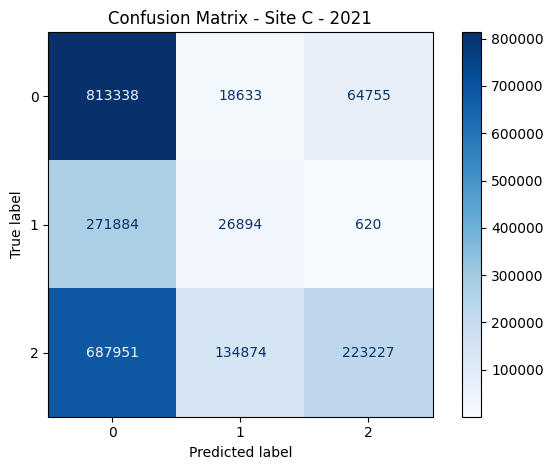

In [21]:
acc, kappa, per_class_f1, avg_f1, cm = validate(model, full_dataloader, T, device=DEVICE)

# Printing and plotting
print("Stochastic" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Per-class F1: {per_class_f1}")
print(f"Average F1 (macro): {avg_f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
plt.tight_layout()
plt.show()

<hr>